## Simple Voting Ensemble

At the end of my previous post on `Which Continent Does PyoungChang Belong To?` I made a simple-voting-based ensemble function. 

Given city name, the ensemble model loads five models and aggregates their inference results, and chooses the most voted continent as its final prediction. This ensemble model's f1-score was 0.571 which was 0.005 higher than the single model's 0.566. 

![simple-voting-based ensemble model](images/simple_voting.png)

Taking advantage of the collaborative power is simple to build and easy to use, but it forced me to set up and train multiple models. Complicated models with large dataset usually take longer than you'd train MNIST or CIFAR10 classifiers. And you'd surely want to find more efficient options when using paid GPUs like FloydHub.

<br>

## Snapshot Ensemble with SGDR

Thanks to a lecture I stumbled upon on the latest CNN architectures, I found the following two brilliant papers:  
1) <a href='https://arxiv.org/pdf/1704.00109.pdf'>SNAPSHOT ENSEMBLES: TRAIN 1, GET M FOR FREE</a>  
2) <a href='https://arxiv.org/pdf/1608.03983.pdf'>SGDR: Stochastic Gradient Descent with Warm Restarts</a>

From a business bachelors degree holder's point of view (where academic breakthroughs are hard to come by these days), I found the way the authors interacted with each other awesome. Loshchilov and Hutter first submitted their paper to Arxiv on SGDR in Aug 2016 which was about eight months before Huang et al.'s submission. Huang et al. stated that their work on Snapshot Ensemble was inspired by Lochchilov and Hutter's work which, in turn, included Huang et al.'s snapshot approach in their revised paper in May 2017. I see this as a typical example of the power of knowledge sharing that frequently happens in deep learning. (love it!)

<br>

How and why they work can be surmised as follows.

1) Learning rate decay is a wide-spread practice these days. We start with a big one as high as 1e-1 and end up with 1e-6 or lower. High learning rate speeds up the learning process, and the small learning rate helps the model to converge to the nearest local minima.

2) The more complex the model is, the more local minima we have. Although the local minima might yield similar errors, the models based on them produce different results. 

3) If $M$ number of local minima produce $M$ different results, we can surely make an ensemble model based on them. Then, what we'd have to do is to train a single model and deliberately guide it to converge to local minima along its optimization path.

![finding local_minima](images/local_minima.png)
(image source: SNAPSHOT ENSEMBLES: TRAIN 1, GET M FOR FREE)

4) How to guide it to the local minima? By annealing learning rate. Set it low to converge to a basin, and set it high to escape it. Here we use the cosine annealing technique suggested by 'SGDR'.

![Annealing learning rate with warm restarts](images/sgdr.png)
(image source: SGDR: Stochastic Gradient Descent with Warm Restarts)

5) At each SGDR reset, save the model checkpoint. The ensemble model averages individual model's last softmax output and produces the final label.

![Snapshot Ensemble](images/snapshot_ensemble.png)


<br>

## Stochastic Gradient Descent with Warm Restarts (SGDR)

Unlike the existing schedule that continuously decreases learning rate, Lochchilov and Hutter's idea was to reset the learning rate once the epoch reaches reset points. And until then, the scheduler reduces it using cosine annealing technique. Here's the equation.

$$ \eta_t = \eta^{i}_{min} + \frac{1}{2} (\eta^{i}_{max} - \eta^{i}_{min})(1 + \cos(\frac{T_{cur}}{T_i}\pi))$$

When the global epoch is 0 or if the scheduler has just reset($T_{cur} = 0$), eta_t becomes eta_max. 
And when the $T_{cur}$ is equal to $T_i$ (reset point), then the right side gets canceled out, leaving eta_min.

To enhance performance, the authors suggest an option to increase $T_i$ by a factor of $T_{mult}$ at every reset.

Pytorch already has SGDR implemented in <a href="http://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html">`torch.optim.lr_scheduler`</a> as `CosineAnnealingLR`, but this version does not reset the learning rate, nor does it increase $T_{i}$ by a factor of $T_{mult}$. So I edited the code a little bit to add the restart function and snapshot save function.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler
torch.manual_seed(1000)

from torchtext import data

In [2]:
class CosineAnnealingLR_with_Restart(_LRScheduler):
    """Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. The original pytorch
    implementation only implements the cosine annealing part of SGDR,
    I added my own implementation of the restarts part.
    
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        T_mult (float): Increase T_max by a factor of T_mult
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
        model (pytorch model): The model to save.
        out_dir (str): Directory to save snapshots
        take_snapshot (bool): Whether to save snapshots at every restart

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, T_mult, model, out_dir, take_snapshot, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_mult = T_mult
        self.Te = self.T_max
        self.eta_min = eta_min
        self.current_epoch = last_epoch
        
        self.model = model
        self.out_dir = out_dir
        self.take_snapshot = take_snapshot
        
        self.lr_history = []
        
        super(CosineAnnealingLR_with_Restart, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        new_lrs = [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.current_epoch / self.Te)) / 2

                for base_lr in self.base_lrs]
        
        self.lr_history.append(new_lrs)
        return new_lrs
    
    def step(self, epoch=None):
        if epoch is None:
        
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1
        
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
        
        ## restart
        if self.current_epoch == self.Te:
            print("restart at epoch {:03d}".format(self.last_epoch + 1))
            
            if self.take_snapshot:
                torch.save({
                    'epoch': self.T_max,
                    'state_dict': self.model.state_dict()
                }, self.out_dir + "/" + 'snapshot_e_{:03d}.pth.tar'.format(self.T_max))
            
            ## reset epochs since the last reset
            self.current_epoch = 0
            
            ## reset the next goal
            self.Te = int(self.Te * self.T_mult)
            self.T_max = self.T_max + self.Te


To see how the scheduler controls the learning rate, I made the following sample model and visualization function.

In [3]:
class BlankModel(nn.Module):
    
    def __init__(self):
        super(BlankModel, self).__init__()
        self.fc = nn.Linear(2, 2)
        
    def foward(self, x):
        x = self.fc(x)
        return x

In [4]:
def simulate_lrs(t_max, t_mult, epochs):
    
    model = BlankModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    sgdr = CosineAnnealingLR_with_Restart(optimizer, T_max=t_max, T_mult=t_mult, model=model, out_dir='blank', \
                                               take_snapshot=False, eta_min=1e-3)
    
    for i in range(epochs):
        sgdr.step()
        lr = optimizer.param_groups[0]['lr']

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot([x[0] for x in sgdr.lr_history])
    ax.set_yscale("log")
    plt.show()

### $T_{max} = 10, T_{mult} = 1$ for 100 epochs

restart at epoch 010
restart at epoch 020
restart at epoch 030
restart at epoch 040
restart at epoch 050
restart at epoch 060
restart at epoch 070
restart at epoch 080
restart at epoch 090
restart at epoch 100


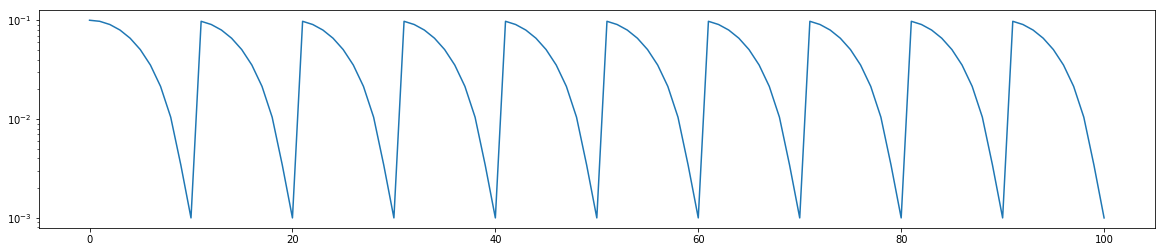

In [5]:
simulate_lrs(10, 1, 100)

### $T_{max} = 10, T_{mult} = 2$ for 100 epochs

restart at epoch 010
restart at epoch 030
restart at epoch 070


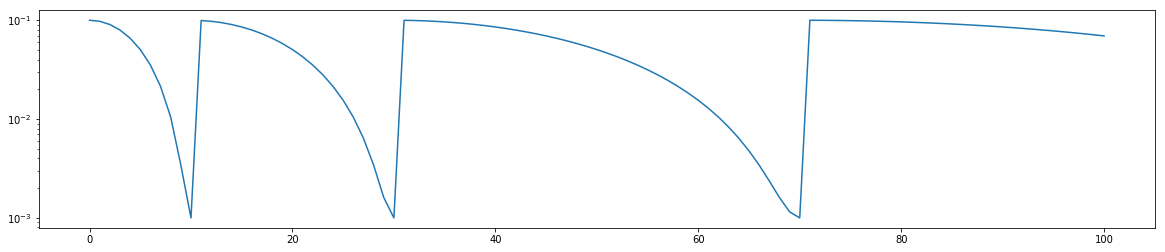

In [6]:
simulate_lrs(10, 2, 100)

### $T_{max} = 1, T_{mult} = 2$ for 100 epochs

restart at epoch 001
restart at epoch 003
restart at epoch 007
restart at epoch 015
restart at epoch 031
restart at epoch 063


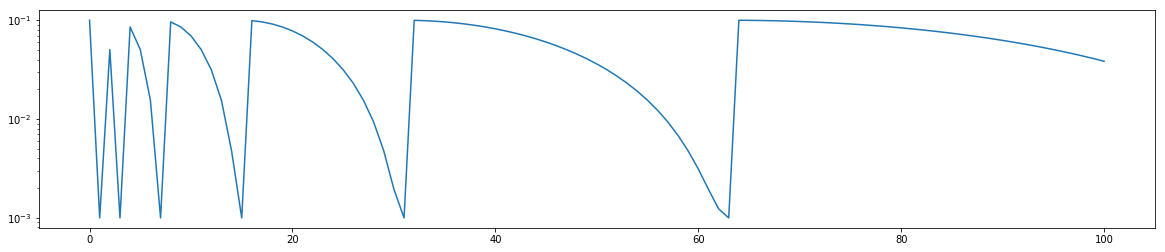

In [7]:
simulate_lrs(1, 2, 100)

## Performance Test

As proven by the various experiments in the authors' papers, SGDR hastens the learning process, and Snapshot Ensemble enhances the predictive power with lower time and effort for training models.

I ran my own petit experiment using the city name dataset to evaluate the usefulness of Snapshot Ensemble with SGDR.

My best model (pg_17) was 3-layered LSTM model with LSTM dropout 0.5 and dense layer dropout 0.5, trained for 12 epochs. And my ensemble model was made up of the top 5 best models including (pg_17). Here are their accuracy and f1-score.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Test Accuracy</th>
    <th class="tg-yw4l">Test f1-score</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Best Single Model</td>
    <td class="tg-yw4l">0.581</td>
    <td class="tg-yw4l">0.566</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Simple Voting Ensemble</td>
    <td class="tg-yw4l">0.589</td>
    <td class="tg-yw4l">0.571</td>
  </tr>
</table>

I tried several versions of SGDR with different $T_max$, $T_{mult}$, epochs. I liked the idea of increasing $T_max$ in a factor of $T_{mult}$ because the model would be benefitted from subtle changes of learning rate when looking for a good local minima. But it turned out that simple sgdr that repeatedly anneals learning rate every 12 epochs showed the best result for this dataset.

I ran sgdr for 120 epochs and got 12 snapshots. Here are their test f1-scores.

![test f1-score of snapshots](images/test_f1score.png)

It seems that the model found good local minima since the third snapshots. The training f1-score were similar to the validation and test metric indicating that the model was robust to the problem of overfitting (training and validation  log in the full code below).

To yield an ensembled prediction I simply averaged softmax outputs of the chosen snapshots(`models[2:]`) and transformed it to the final label.

As a result...

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l">Test Accuracy</th>
    <th class="tg-yw4l">Test f1-score</th>
  </tr>
  <tr>
    <td class="tg-yw4l">Best Single Model</td>
    <td class="tg-yw4l">0.581</td>
    <td class="tg-yw4l">0.566</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Simple Voting Ensemble</td>
    <td class="tg-yw4l">0.589</td>
    <td class="tg-yw4l">0.571</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Snapshot Esemble</td>
    <td class="tg-yw4l">0.596</td>
    <td class="tg-yw4l">0.585<br></td>
  </tr>
</table>

The Snapshot Ensemble's test accuracy and f1-score increased by 0.007 and 0.014 respectively compared to the simple ensemble model. It may not be an outstanding improvement, but (to me) it is an unexpected result when the individual snapshots were inferior even to the best single model by the margin of more than 0.02.

Two heads are better than one. And it gets even better when you don't even need two bodies.

## Reference

1) <a href='https://arxiv.org/pdf/1704.00109.pdf'>SNAPSHOT ENSEMBLES: TRAIN 1, GET M FOR FREE</a>  
2) <a href='https://arxiv.org/pdf/1608.03983.pdf'>SGDR: Stochastic Gradient Descent with Warm Restarts</a>

## Full Training Code

In [8]:
## City name tokenizer
## 'Seoul' -> ['S', 'e', 'o', 'u', 'l']
def tokenizer(text):
    return list(text)

tokenizer("Seoul")

['S', 'e', 'o', 'u', 'l']

In [9]:
CITY = data.Field(sequential=True, pad_first=True, tokenize=tokenizer)
CONTINENT = data.Field(sequential=False, use_vocab=True)

In [10]:
train, val, test = data.TabularDataset.splits(
    path='dataset', skip_header=True, train='_train.csv',
    validation='_val.csv', test='_test.csv', format='csv',
    fields=[('city_ascii', CITY), ('continent', CONTINENT)]
)

In [11]:
CITY.build_vocab(train, val, test)
CONTINENT.build_vocab(train, val, test)

In [12]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_sizes=(16, 16, 16), repeat=False,
    sort_key=lambda x: len(x.city_ascii), device=-1
)

In [13]:
use_gpu = torch.cuda.is_available()

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, vocab_size, label_size,
                 embedding_dim, hidden_dim,
                 nb_lstm_layers, lstm_dropout, lstm_bidirectional,
                 fc_dropout, use_gpu):
        super(LSTMModel, self).__init__()
        
        self.use_gpu = use_gpu
        
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.label_size = label_size
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self.nb_lstm_layers = nb_lstm_layers
        self.lstm_dropout = lstm_dropout
        self.lstm_bidirectional = lstm_bidirectional
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=self.nb_lstm_layers, 
                            dropout=self.lstm_dropout,
                            bidirectional=self.lstm_bidirectional)
        
        if self.lstm_bidirectional:
            self.hidden2label = nn.Linear(hidden_dim * 2, label_size)
        else:
            self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()
        self.dropout = nn.Dropout(fc_dropout)
        
        
    def init_hidden(self):
        if self.lstm_bidirectional:
            if self.use_gpu:
                return (Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim).cuda()),
                        Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim).cuda()))
            else:
                return (Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim)),
                        Variable(torch.zeros(self.nb_lstm_layers * 2, self.batch_size, self.hidden_dim)))
        else:
            if self.use_gpu:
                return (Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim).cuda()),
                        Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim).cuda()))
            else:
                return (Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim)),
                        Variable(torch.zeros(self.nb_lstm_layers, self.batch_size, self.hidden_dim)))
                
    
    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        y = self.dropout(y)
        log_probs = F.log_softmax(y)
        return log_probs

In [15]:
def load_params(modelClass, pg, use_gpu):
    model = modelClass(batch_size = pg['BATCH_SIZE'],
                  vocab_size = len(CITY.vocab),
                  label_size = len(CONTINENT.vocab) -1, ## b.c of <unk>
                  embedding_dim = pg['EMBEDDING_DIM'],
                  hidden_dim = pg['HIDDEN_DIM'],
                  nb_lstm_layers = pg['nb_1stm_layers'],
                  lstm_dropout = pg['lstm_dropout'],
                  lstm_bidirectional=pg['lstm_bidirectional'],
                  fc_dropout = pg['fc_dropout'],
                  use_gpu = use_gpu)
    if use_gpu:
        return model.cuda()
    else:
        return model

In [16]:
pg_17 = {'BATCH_SIZE': 32,
 'EMBEDDING_DIM': 100,
 'HIDDEN_DIM': 100,
 'fc_dropout': 0.5,
 'lstm_bidirectional': True,
 'lstm_dropout': 0.5,
 'nb_1stm_layers': 3}

In [17]:
pg_17_model = load_params(LSTMModel, pg_17, use_gpu)

In [18]:
import numpy as np
from torch import optim
import torch.nn.functional as F

In [19]:
out_dir = os.path.abspath(os.path.join(os.path.curdir, "sgdr_7"))
    
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [20]:
def get_accuracy(truth, pred):
    tr = np.array(truth)
    pr = np.array(pred)
    return sum(tr == pr) / len(tr)

In [21]:
from sklearn.metrics import f1_score
def get_f1(truth, pred):
    tr = np.array(truth)
    pr = np.array(pred)
    return f1_score(tr, pr, average='weighted')

In [22]:
from torch.optim.lr_scheduler import _LRScheduler
import math

In [23]:
import time
loss_function = nn.NLLLoss()
optimizer = optim.SGD(pg_17_model.parameters(), lr=0.1, momentum=0.9, nesterov=True)

In [24]:
mySGDR = CosineAnnealingLR_with_Restart(optimizer, T_max=12, T_mult=1, model=pg_17_model, out_dir=out_dir, \
                                        take_snapshot=True, eta_min=1e-9)

In [25]:
def train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch):
    
    model.train() ## train mode
    
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    count = 0
        
    for batch in train_iter:
        if use_gpu:
            city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
        else:
            city, continent = batch.city_ascii, batch.continent
        continent.data.sub_(1) ## -1 to make index start from 0 (0 is <unk> in the vocab)
        truth_res += list(continent.data)
        
        model.batch_size = len(continent.data)
        model.hidden = model.init_hidden()
        
        pred = model(city)
        pred_label = pred.data.max(1)[1].cpu().numpy() ## .cpu() to get it from gpu env
        pred_res += [x for x in pred_label]
        
        model.zero_grad()
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
        count += 1
        
        loss.backward()
        optimizer.step()
        
    avg_loss /= len(train_iter)
    acc = get_accuracy(truth_res, pred_res)
    f1 = get_f1(truth_res, pred_res)
    
    print('Train: loss %.2f | acc %.1f | f1-score %.3f' % (avg_loss, acc * 100, f1))
        
    return avg_loss, acc, f1

In [26]:
def evaluate(model, data, loss_function, name):
    
    model.eval() ## eval mode
    
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    
    for batch in data:
        if use_gpu:
            city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
        else:
            city, continent = batch.city_ascii, batch.continent
        continent.data.sub_(1)
        truth_res += list(continent.data)
        
        model.batch_size = len(continent.data)
        model.hidden = model.init_hidden()
        
        pred = model(city)
        pred_label = pred.data.max(1)[1].cpu().numpy()
        pred_res += [x for x in pred_label]
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
        
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    f1 = get_f1(truth_res, pred_res)
    
    print(name + ': loss %.2f | acc %.1f | f1-score %.3f' % (avg_loss, acc * 100, f1))
    return avg_loss, acc, f1

In [27]:
EPOCHS = 121

In [28]:
import time

In [29]:
loss_function = nn.NLLLoss()

In [30]:
for epoch in range(EPOCHS):
    
    print("Epoch: {}".format(epoch + 1))
    mySGDR.step()
    
    rec_dict = {}
    train_loss, acc, train_f1 = train_epoch_progress(pg_17_model, 
                                     train_iter, 
                                     loss_function, 
                                     optimizer,
                                     CITY, 
                                     CONTINENT, 
                                     epoch)

    val_loss, val_acc, val_f1 = evaluate(pg_17_model, val_iter, loss_function, 'Val')
    

test_loss, test_acc, test_f1 = evaluate(pg_17_model, test_iter, loss_function, 'Final Test')
     

Epoch: 1
Train: loss 1.68 | acc 32.7 | f1-score 0.285
Val: loss 1.46 | acc 43.1 | f1-score 0.336
Epoch: 2
Train: loss 1.60 | acc 38.4 | f1-score 0.353
Val: loss 1.45 | acc 47.2 | f1-score 0.397
Epoch: 3
Train: loss 1.56 | acc 40.5 | f1-score 0.377
Val: loss 1.40 | acc 48.5 | f1-score 0.482
Epoch: 4
Train: loss 1.53 | acc 42.1 | f1-score 0.394
Val: loss 1.32 | acc 54.5 | f1-score 0.525
Epoch: 5
Train: loss 1.49 | acc 44.2 | f1-score 0.416
Val: loss 1.35 | acc 48.6 | f1-score 0.424
Epoch: 6
Train: loss 1.47 | acc 43.9 | f1-score 0.413
Val: loss 1.31 | acc 52.5 | f1-score 0.508
Epoch: 7
Train: loss 1.45 | acc 44.7 | f1-score 0.425
Val: loss 1.27 | acc 55.5 | f1-score 0.540
Epoch: 8
Train: loss 1.41 | acc 47.4 | f1-score 0.451
Val: loss 1.24 | acc 54.3 | f1-score 0.520
Epoch: 9
Train: loss 1.39 | acc 47.0 | f1-score 0.447
Val: loss 1.22 | acc 55.1 | f1-score 0.529
Epoch: 10
Train: loss 1.37 | acc 47.6 | f1-score 0.455
Val: loss 1.23 | acc 55.7 | f1-score 0.547
Epoch: 11
Train: loss 1.36 | 

Train: loss 1.04 | acc 59.4 | f1-score 0.581
Val: loss 1.43 | acc 54.0 | f1-score 0.538
Epoch: 85
Train: loss 1.16 | acc 56.5 | f1-score 0.550
Val: loss 1.35 | acc 54.2 | f1-score 0.535
Epoch: 86
Train: loss 1.19 | acc 54.5 | f1-score 0.530
Val: loss 1.42 | acc 52.8 | f1-score 0.525
Epoch: 87
Train: loss 1.19 | acc 54.6 | f1-score 0.531
Val: loss 1.27 | acc 55.1 | f1-score 0.534
Epoch: 88
Train: loss 1.16 | acc 56.2 | f1-score 0.546
Val: loss 1.37 | acc 52.9 | f1-score 0.529
Epoch: 89
Train: loss 1.16 | acc 56.6 | f1-score 0.550
Val: loss 1.34 | acc 54.5 | f1-score 0.541
Epoch: 90
Train: loss 1.13 | acc 57.0 | f1-score 0.553
Val: loss 1.40 | acc 54.0 | f1-score 0.541
Epoch: 91
Train: loss 1.10 | acc 57.5 | f1-score 0.559
Val: loss 1.43 | acc 53.2 | f1-score 0.530
Epoch: 92
Train: loss 1.05 | acc 59.2 | f1-score 0.577
Val: loss 1.47 | acc 53.8 | f1-score 0.539
Epoch: 93
Train: loss 1.02 | acc 60.8 | f1-score 0.595
Val: loss 1.49 | acc 54.5 | f1-score 0.542
Epoch: 94
Train: loss 1.01 | a

In [31]:
import glob

In [70]:
out_dir = 'sgdr_final'
checkpoints = sorted(glob.glob(out_dir + '/*.tar'))

In [71]:
checkpoints

['sgdr_final/snapshot_e_012.pth.tar',
 'sgdr_final/snapshot_e_024.pth.tar',
 'sgdr_final/snapshot_e_036.pth.tar',
 'sgdr_final/snapshot_e_048.pth.tar',
 'sgdr_final/snapshot_e_060.pth.tar',
 'sgdr_final/snapshot_e_072.pth.tar',
 'sgdr_final/snapshot_e_084.pth.tar',
 'sgdr_final/snapshot_e_096.pth.tar',
 'sgdr_final/snapshot_e_108.pth.tar',
 'sgdr_final/snapshot_e_120.pth.tar']

In [72]:
model = load_params(LSTMModel, pg_17, use_gpu)
ch = torch.load(checkpoints[0], map_location={'cuda:0':'cpu'})
model.load_state_dict(ch['state_dict'])

In [73]:
def load_model(path):
    model = load_params(LSTMModel, pg_17, use_gpu)
    ch = torch.load(path, map_location={'cuda:0':'cpu'})
    model.load_state_dict(ch['state_dict'])
    return model

In [74]:
models = [load_model(ch) for ch in checkpoints]

Final Test: loss 1.23 | acc 55.3 | f1-score 0.532
Final Test: loss 1.19 | acc 55.6 | f1-score 0.537
Final Test: loss 1.21 | acc 57.4 | f1-score 0.562
Final Test: loss 1.26 | acc 57.3 | f1-score 0.562
Final Test: loss 1.31 | acc 58.2 | f1-score 0.574
Final Test: loss 1.38 | acc 56.8 | f1-score 0.562
Final Test: loss 1.45 | acc 56.2 | f1-score 0.555
Final Test: loss 1.52 | acc 57.1 | f1-score 0.564
Final Test: loss 1.59 | acc 56.4 | f1-score 0.559
Final Test: loss 1.56 | acc 55.9 | f1-score 0.555


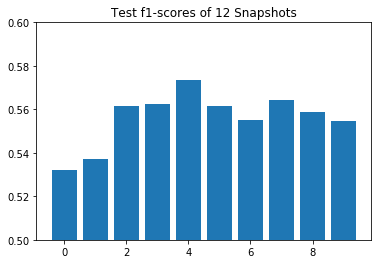

In [75]:
f1_list = []
for model in models:
    test_loss, test_acc, test_f1 = evaluate(model, test_iter, loss_function, 'Final Test')
    f1_list.append(test_f1)
    
fig, ax = plt.subplots()
ax.bar(np.arange(0, len(f1_list)), f1_list)

ax.set_ylim(0.5, 0.6)

ax.set_title("Test f1-scores of 12 Snapshots")
plt.show()

In [91]:
chosen = models[2:]

In [92]:
def ensemble_evaluate(models, data, loss_function, name):
    tot = []
    for model in models:
        preds = []
        label = []
        model.eval() ## eval mode

        avg_loss = 0.0
        truth_res = []
        pred_res = []

        for batch in data:
            if use_gpu:
                city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
            else:
                city, continent = batch.city_ascii, batch.continent
            continent.data.sub_(1)
            truth_res += list(continent.data)

            model.batch_size = len(continent.data)
            model.hidden = model.init_hidden()

            pred = model(city)
            preds.append(pred)
            label.append(continent)
        tot.append(preds)
    return tot, label

In [93]:
def ensemble_evaluate(models, data, loss_function, name):

    avg_loss = 0.0
    truth_res = []
    pred_res = []

    for batch in data:
        batch_pred = []
        
        for model in models:
            
            model.eval()
            
            if use_gpu:
                city, continent = batch.city_ascii.cuda(), batch.continent.cuda()
            else:
                city, continent = batch.city_ascii, batch.continent
            continent.data.sub_(1)
            
            
            model.batch_size = len(continent.data)
            model.hidden = model.init_hidden()

            pred = model(city)
            batch_pred.append(pred)
            
        truth_res += list(continent.data)
            
        stacked_pred = torch.stack([t.data for t in batch_pred])
        ensemble_pred = torch.mean(stacked_pred, dim=0)
        ensemble_label = ensemble_pred.max(1)[1].cpu().numpy()
        pred_res += [x for x in ensemble_label]
            
        loss = loss_function(pred, continent)
        avg_loss += loss.data[0]
            
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    f1 = get_f1(truth_res, pred_res)
    
    return avg_loss, acc, f1




In [94]:
avg_loss, acc, f1 = ensemble_evaluate(chosen, test_iter, loss_function, "final test")

In [95]:
print(avg_loss, acc, f1)

1.560901219430177 0.59612724758 0.585357612011


In [96]:
def ensemble_inference(models, target, use_gpu):
    
    pred_res = []
    for model in models:
        model.eval()
        model.batch_size = 1
        
        if use_gpu:
            targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).cuda().type(torch.LongTensor).view(len(target), -1)).cuda()
        else:
            targetTensor = Variable(torch.Tensor([CITY.vocab.stoi[c] for c in CITY.preprocess(target)]).type(torch.LongTensor).view(len(target), -1))
        
        model.hidden = model.init_hidden()
        
        pred = model(targetTensor)
        pred_res.append(pred)
        
    stacked_pred = torch.stack([t.data for t in pred_res])
    ensemble_pred = torch.mean(stacked_pred, dim=0)
    res_df = pd.DataFrame([(idx, pred_val) for idx, pred_val in enumerate(ensemble_pred.cpu().numpy()[0])], columns=['res_idx', 'nll'])
    res_df['prob'] = res_df.nll.map(lambda x: round(np.exp(x), 3))
    res_df['continent'] = res_df.res_idx.map(lambda x: CONTINENT.vocab.itos[x+1])
    res_df = res_df.sort_values(by='prob', ascending=False)
    return res_df

In [97]:
ensemble_inference(models, 'Pyeongchang', use_gpu)

,res_idx,nll,prob,continent
0,0,-0.006906,0.993,Asia
1,1,-9.892464,0.000,North America
2,2,-8.771552,0.000,Africa
3,3,-10.246568,0.000,South America
4,4,-9.245982,0.000,Europe
5,5,-9.318214,0.000,Oceania


In [98]:
ensemble_inference(models, 'Pyongyang', use_gpu)

,res_idx,nll,prob,continent
0,0,-0.006043,0.994,Asia
1,1,-10.383581,0.000,North America
2,2,-9.277002,0.000,Africa
3,3,-10.818215,0.000,South America
4,4,-9.842393,0.000,Europe
5,5,-9.806544,0.000,Oceania


In [99]:
ensemble_inference(models, 'Sheffield', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.251214,0.778,North America
5,5,-3.087586,0.046,Oceania
2,2,-3.453455,0.032,Africa
4,4,-3.497353,0.030,Europe
0,0,-4.547478,0.011,Asia
3,3,-5.292456,0.005,South America


In [100]:
ensemble_inference(models, 'Bratford', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.845049,0.430,North America
4,4,-1.327268,0.265,Europe
5,5,-2.198355,0.111,Oceania
2,2,-2.554528,0.078,Africa
0,0,-3.445377,0.032,Asia
3,3,-3.488388,0.031,South America


In [101]:
ensemble_inference(models, 'York', use_gpu)

,res_idx,nll,prob,continent
1,1,-0.890224,0.411,North America
4,4,-1.868993,0.154,Europe
0,0,-1.892135,0.151,Asia
2,2,-2.067101,0.127,Africa
5,5,-2.372786,0.093,Oceania
3,3,-3.830435,0.022,South America
